<a href="https://colab.research.google.com/github/vanthao43st/ImageCaptioning/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import efficientnet
from tensorflow.keras import layers

print(tf.__version__)
tf.keras.utils.set_random_seed(111)

2.18.0


In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

##Initialize parameters for the model

In [3]:
IMAGE_PATH = "Flicker8k_Dataset"

IMAGE_SIZE = (299, 299)

VOCAB_SIZE = 10000

SEQ_LENGTH = 25

EMBED_DIM = 512

FF_DIM = 512

BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset

In [4]:
def load_caption_data(filename):
    with open(filename) as f:
        caption_data = f.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            img_name, caption = line.split("\t")
            img_name = img_name.split("#")[0]
            img_path = os.path.join(IMAGE_PATH, img_name.strip())

            tokens = caption.strip().split()
            if (len(tokens) < 5 or len(tokens) > SEQ_LENGTH):
                images_to_skip.add(img_path)
                continue

            if img_path.endswith("jpg") and img_path not in images_to_skip:
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)
                if img_path not in caption_mapping:
                    caption_mapping[img_path] = list()
                caption_mapping[img_path].append(caption)

    for img_path in images_to_skip:
        if img_path in caption_mapping:
            del caption_mapping[img_path]

    return caption_mapping, text_data

caption_mapping, text_data = load_caption_data("Flickr8k.token.txt")
print(len(caption_mapping))
print(caption_mapping)

7643
{'Flicker8k_Dataset/1000268201_693b08cb0e.jpg': ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>'], 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg': ['<start> A black dog and a spotted dog are fighting <end>', '<start> A black dog and a tri-colored dog playing with each other on the road . <end>', '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>', '<start> Two dogs of different breeds looking at each other on the road . <end>', '<start> Two dogs on pavement moving toward each other . <end>'], 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg': ['<start> A little girl covered in paint sits in front of a painted rainbow with her hands in

In [5]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    all_image_paths = list(caption_data.keys())
    if shuffle:
        np.random.shuffle(all_image_paths)

    train_size = int(len(caption_data) * train_size)
    train_ds = {
        img_path: caption_data[img_path] for img_path in all_image_paths[:train_size]
    }
    val_ds = {
        img_path: caption_data[img_path] for img_path in all_image_paths[train_size:]
    }

    return train_ds, val_ds

train_ds, val_ds = train_val_split(caption_mapping)
print("Number of training samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))

Number of training samples:  6114
Number of validation samples:  1529


##The TextVectorization class normalizes, encodes, and vectorizes data.

In [6]:
stripped_punctuation = string.punctuation.replace("<", "").replace(">", "")
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(stripped_punctuation), "")

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH
)

vectorize_layer.adapt(text_data)

##Size of vectorize_layer

In [7]:
len(vectorize_layer.get_vocabulary())
vectorize_layer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('<start>'),
 np.str_('<end>'),
 np.str_('in'),
 np.str_('the'),
 np.str_('on'),
 np.str_('is'),
 np.str_('and')]

##Building a Dataset pipeline for training

In [8]:
def decode_and_resize(img_path):
    # Read image file as binary file
    img = tf.io.read_file(img_path)

    # jpeg image encoding with 3 color channels
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize image to fit model
    img = tf.image.resize(img, IMAGE_SIZE)

    # Normalize image pixels to within the range [0, 255]
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def process_input_data(img_path, captions):
    return decode_and_resize(img_path), vectorize_layer(captions)

def make_dataset(img_path, captions):
  # Create a TensorFlow dataset from two tensors: image paths and their corresponding captions
    dataset = tf.data.Dataset.from_tensor_slices((img_path, captions))

    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input_data, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    # Prefetch the next batches while the current one is being processed, improving pipeline efficiency
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

train_dataset = make_dataset(list(train_ds.keys()), list(train_ds.values()))
val_dataset = make_dataset(list(val_ds.keys()), list(val_ds.values()))

**Data augmentation**

In [9]:
image_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.3)
])

##Build model cnn and Transformer

**Build CNN model**

In [10]:
def get_cnn_model():
    # Load the EfficientNetB0 model without the top classification layer, using pretrained ImageNet weights
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),     # Input shape is (height, width, 3 channels for RGB)
        include_top=False,                # Do not include the final dense classification layer
        weights="imagenet"                # Load pretrained weights from ImageNet
    )

    # Freeze all layers in the base model to prevent them from being updated during training
    base_model.trainable = False

    # Get the output tensor of the base model (feature maps)
    base_model_out = base_model.output

    # Reshape the 4D output (batch, height, width, channels) into 3D (batch, sequence_length, feature_dim)
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

    # Create a new model that maps input images to the reshaped feature vectors
    cnn_model = tf.keras.models.Model(base_model.input, base_model_out)

    return cnn_model



In [11]:
# help(tf.keras.layers.Embedding)

**Build Transformer Architecture**

In [12]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_head, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim         # Store the embedding dimension (used for attention and projection layers)
        self.dense_dim = dense_dim         # Used in the feed-forward network
        self.num_head = num_head

        # Initialize a Multi-Head Attention layer
        # - num_heads: number of parallel attention heads
        # - key_dim: dimensionality of each attention head (per head key/query vector)
        # - dropout: dropout rate applied to attention weights (0.0 = no dropout)
        self.multiHeadAttention = layers.MultiHeadAttention(
            num_heads=num_head,
            key_dim=embed_dim,
            dropout=0.0
        )

        # First Layer Normalization layer, typically applied before/after attention block
        self.layernormalization_1 = layers.LayerNormalization()

        # Second Layer Normalization layer, typically used after the feed-forward network
        self.layernormlization_2 = layers.LayerNormalization()

        # First Dense layer in the position-wise feed-forward network, using ReLU activation
        self.dense_1 = layers.Dense(dense_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernormalization_1(inputs)
        inputs = self.dense_1(inputs)
        attention_output = self.multiHeadAttention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training
        )
        out_1 = self.layernormlization_2(inputs + attention_output)
        return out_1

class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
        )

        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

        self.position_embedding = layers.Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim
        )

    def call(self, inputs):
        embedded_tokens = self.token_embedding(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        length = tf.shape(inputs)[-1]                           # inputs.shape = (batch_size, sequence_length)
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embedding(positions)
        return embedded_tokens + embedded_positions

    # Automatically generate masks for elements in inputs, marking which are valid tokens and which are <PAD> (padding)
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.position_embedding = PositionEmbedding(
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
            embed_dim=embed_dim
        )

        # First Multi-Head Self-Attention layer (Masked self-attention in the decoder)
        self.multiHeadAttention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=0.1
        )
        # Second Multi-Head Attention layer (Encoder-Decoder attention)
        self.multiHeadAttention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=0.1
        )

        # First dense layer of the position-wise feed-forward network (FFN)
        self.ffn_1 = layers.Dense(ff_dim, activation='relu')
        # Second dense layer that projects back to embed_dim
        self.ffn_2 = layers.Dense(embed_dim)

        # Layer normalization after the first attention block
        self.layernormalization_1 = layers.LayerNormalization()
        # Layer normalization after the second attention block
        self.layernormalization_2 = layers.LayerNormalization()
        # Layer normalization after the feed-forward network (FFN)
        self.layernormalization_3 = layers.LayerNormalization()

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)

        self.out = layers.Dense(VOCAB_SIZE, activation='softmax')

        self.supports_masking = True

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult= tf.concat(
            [
                tf.expand_dims(batch_size, axis=-1),
                tf.constant([1, 1], dtype=tf.int32)
            ],
            axis=0
        )

        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, training, mask=None):
        # Convert token indices into embedding vectors (with positional encoding)
        inputs = self.position_embedding(inputs)
        # Create a causal mask to prevent attention to future tokens (for autoregressive decoding)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            # 2 different ways to expand the dimension
            padding_mask = tf.cast(tf.expand_dims(mask, axis=-1), dtype=tf.int32)         # tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

            # Combine the padding mask with the causal mask for self-attention
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # Multi-head self-attention with look-ahead masking (decoder attends to itself)
        multiHeadAttention_output_1 = self.multiHeadAttention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training
        )

        output_1 = self.layernormalization_1(inputs + multiHeadAttention_output_1)

        # Multi-head cross-attention (decoder attends to encoder outputs)
        multiHeadAttention_output_2 = self.multiHeadAttention_2(
            query=output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training
        )

        output_2 = self.layernormalization_2(output_1 + multiHeadAttention_output_2)

        # Feed-forward network (position-wise)
        ffn_output = self.ffn_1(output_2)
        ffn_output = self.dropout_1(ffn_output, training=training)

        # Project back to embedding dimension and apply residual connection + norm
        ffn_output = self.ffn_2(ffn_output)
        ffn_output = self.layernormalization_3(output_2 + ffn_output)

        ffn_output = self.dropout_2(ffn_output, training=training)

        # Project to vocabulary space using final softmax layer to predict next token
        predictions = self.out(ffn_output)

        return predictions

##View constructor and call properties of available layers

In [13]:
help(tf.keras.layers.Dropout.call)
# help(tf.keras.layers.Dropout)
help(tf.keras.Model.loss)

Help on function call in module keras.src.layers.regularization.dropout:

call(self, inputs, training=False)

Help on function loss in module keras.src.backend.tensorflow.trainer:

loss(self, y, y_pred, sample_weight=None)



##Design image captioning model

In [14]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        # Track average loss and accuracy after each batch.
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")

    def caculate_loss(self, y_true, y_pred, mask):
        # Compute the raw loss (e.g., categorical crossentropy) between true and predicted values
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        # Apply the mask to the loss — only keep losses at valid (non-padded) positions
        loss *= mask
        # Return the average loss over only the valid (non-masked) positions
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def caculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=accuracy.dtype)
        accuracy *= mask
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def compute_loss_and_acc(self, img_embed, batch_sequence, training=True):
        # Pass image embeddings through the encoder
        encoder_output = self.encoder(img_embed, training=training)

        # Prepare decoder inputs by shifting the sequence one step to the right
        batch_sequence_input = batch_sequence[:, :-1]       # Input to the decoder (start tokens to last-1)
        batch_sequence_true = batch_sequence[:, 1:]         # True target sequence (second token to end)

        # Create a mask to ignore padding tokens (token ID = 0)
        mask = tf.math.not_equal(batch_sequence_true, 0)

        # Run the decoder to get predictions for the next tokens
        batch_sequence_prediction = self.decoder(
            batch_sequence_input,
            encoder_output,
            training=training,
            mask=mask
        )

        loss = self.caculate_loss(batch_sequence_true, batch_sequence_prediction, mask)
        acc = self.caculate_accuracy(batch_sequence_true, batch_sequence_prediction, mask)

        return loss, acc


    # Override Train & Test Step
    def train_step(self, batch_data):
        batch_image, batch_sequence = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_image = self.image_aug(batch_image)

        # Get image embeddings
        img_embed = self.cnn_model(batch_image)

        for i in range(self.num_captions_per_image):
            # Tape sẽ ghi lại toàn bộ quá trình tính loss: qua encoder, decoder, attention, embedding.
            # Ghi lại các phép toán để sau đó tự động tính đạo hàm phục vụ tối ưu. Mọi phép toán từ đây sẽ được "ghi nhớ" để backpropagate.
            with tf.GradientTape() as tape:
                loss, acc = self.compute_loss_and_acc(
                    img_embed,
                    batch_sequence[:, i, :],      # (batch_size, num_captions_per_image, sequence_length)
                    training=True
                )

                # Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # Get all weights to train
            train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)

            # Take the derivative of loss with respect to each weight
            grads = tape.gradient(loss, train_vars)

            # zip(grads, train_vars) generates each pair (gradient, weight)
            # apply_gradients() will update each weight using the formula: W_new = W_old - learning_rate * grad
            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    def test_step(self, batch_data):
        batch_image, batch_sequence = batch_data
        batch_loss = 0
        batch_acc = 0

        img_embed = self.cnn_model(batch_image)
        for i in range(self.num_captions_per_image):
            loss, acc = self.compute_loss_and_acc(
                img_embed,
                batch_sequence[:, i, :],
                training=False
            )

            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    # Define the list of metrics to track during training and evaluation
    # This allows Keras to automatically call `reset_states()` on each metric between epochs
    # and to include them in logs (e.g., in model.fit and model.evaluate)
    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [15]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_head=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    num_captions_per_image=5,
    image_aug=image_augmentation
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model Training

In [16]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None
)

# If val_loss does not improve within 3 epochs → stop early
# restore_best_weights=True: return best weights instead of last epoch.
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Custom learning rate schedule with a linear warmup phase
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        # Target learning rate after warmup is complete
        self.post_warmup_learning_rate = post_warmup_learning_rate

        # Number of warmup steps during which learning rate will linearly increase
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # Compute progress of warmup (0,1)
        warmup_progress = global_step / warmup_steps

        # Linearly scale the learning rate during warmup
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress

        # Condition: If still in warmup phase, return scaled learning rate
        # Otherwise, return the constant post-warmup learning rate
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate
        )

# Calculate the total number of training steps (batches) across all epochs
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

caption_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.1332 - loss: 35.2527 - val_accuracy: 0.3126 - val_loss: 20.4048
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 92s 960ms/step - accuracy: 0.3218 - loss: 19.9179 - val_accuracy: 0.3532 - val_loss: 17.9274
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 92s 960ms/step - accuracy: 0.3553 - loss: 17.7195 - val_accuracy: 0.3696 - val_loss: 16.8536
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3752 - loss: 16.5082 - val_accuracy: 0.3834 - val_loss: 16.2045
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3903 - loss: 15.6574 - val_accuracy: 0.3910 - val_loss: 15.7769
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4032 - loss: 14.9730 - val_accuracy: 0.3991 - val_loss: 15.4306
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 132s 961ms/step - accuracy: 0.4134 - loss: 14.4069 - val_accuracy: 0.4040 - val_loss: 15.2927
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 92s 960ms/step - accuracy: 0.4228 - loss: 13.9387 - 

## Check sample predictions

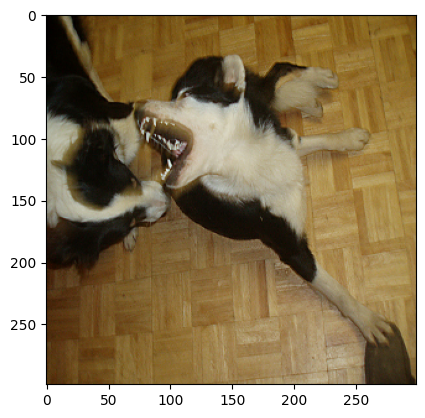

Predicted Caption:  a black and white dog is standing on a wooden floor


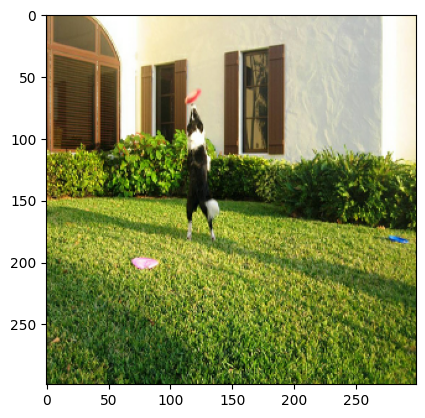

Predicted Caption:  a white dog is running through a field of grass


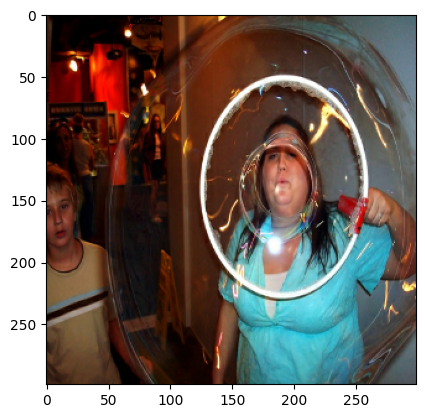

Predicted Caption:  a girl in a blue dress is sitting in a blue chair


In [22]:
vocab = vectorize_layer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(val_ds.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorize_layer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()